Import

In [ ]:
!pip install sympy

In [1]:
# from web3 import Web3
import pandas as pd
pd.set_option('display.max_rows', 200)
from tqdm import tqdm
import ast #eval() to interpret code
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
tqdm.pandas()
import time
import warnings
warnings.filterwarnings('ignore')
from pandas import Timestamp
# from scipy.optimize import fsolve
import sympy as sp
import scipy.optimize as optimize

In [2]:
df = pd.read_csv('complete_eth_tab.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

calculate debt

In [100]:
new_col = None
df.insert(loc = 8,column = 'debt', value = new_col)

In [133]:
def calculate_debt(df):
    ''' 
    To find cumulative debts in each transactions by considers these cases

        case I: liquidate case with the whole amount, debt should be 0
        case II: payback with the whole amount, debt should be 0

    '''
    all_usr = list(df['usr'].unique())

    for usr in tqdm(all_usr):
        tab = df[df['usr'] == usr]

        debt = tab['dai'].iat[0]
        for idx, row in tab.iterrows():
            
            if row['user_action'] == 'liquidate' or row['user_action'] == 'payback dai' or row['user_action'] == 'transfer out':
                amount = -row['dai']

                if amount > debt:
                    debt = 0.0
                    df['debt'].loc[idx] = debt
                else:
                    debt += row['dai']
                    df['debt'].loc[idx] = debt
                    
            else:
                debt += row['dai']
                df['debt'].loc[idx] = debt
                

    return df

In [141]:
debt = calculate_debt(df)

100%|██████████| 18901/18901 [23:27<00:00, 13.43it/s] 


In [145]:
debt.to_csv('debt.csv')

In [144]:
debt[debt['usr']=='0x1D3E2510489c6E17F31D07CE0E584a632D1DF7Fa']

,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,fee,debt,dai(in exchange),rate(DAI/USD),ETH_price,CR_Rate,Liquidate_Rate
52822,0x1D3E2510489c6E17F31D07CE0E584a632D1DF7Fa,ETH-A,0xb7ddcd34e593fc816dc3f64f257fb52b149b35b6806d...,2020-08-13 23:55:54+00:00,lock asset,3.000,0.0,0.0,0.0,0.0000,1.020042,418.520000,0.0000,1.5
52823,0x1D3E2510489c6E17F31D07CE0E584a632D1DF7Fa,ETH-A,0xb7ddcd34e593fc816dc3f64f257fb52b149b35b6806d...,2020-08-13 23:55:54+00:00,generate dai,0.000,500.0,0.0,500.0,490.1760,1.020042,418.520000,2.5111,1.5
52824,0x1D3E2510489c6E17F31D07CE0E584a632D1DF7Fa,ETH-A,0x9e752d6ad681619c01cb8949b69f8e8acdac38d6f101...,2020-08-14 01:22:04+00:00,payback dai,0.000,-480.0,0.0,20.0,-470.5689,1.020042,426.240774,63.9361,1.5
52825,0x1D3E2510489c6E17F31D07CE0E584a632D1DF7Fa,ETH-A,0xed7948db14e21067fbda7c2b1d7b6939e7b79a502768...,2020-08-16 06:02:18+00:00,unlock asset,-2.923,0.0,0.0,20.0,0.0000,1.020042,429.106844,1.6521,1.5
52826,0x1D3E2510489c6E17F31D07CE0E584a632D1DF7Fa,ETH-A,0xeb7cee35a195a979ce618c1bdf537f3ac23525142a66...,2020-08-21 23:00:01+00:00,liquidate,-0.077,-20.0,0.0,0.0,-19.6070,1.020042,388.452964,1.4955,1.5


Calulate LER

In [176]:
def define_status(debt_amount, usr_act):
    '''  
    To define 4 status of debts:
        liquidate - liquidate by the whole amount of debt(debt = 0)
        restruct - liquidate by the partial amount of debt(debt > 0)
        repaid - user payback debt in the whole amount(debt = 0)
        transfer out - user transfer debt out in the whole amount(debt = 0)
        active - debt is still active(debt > 0)
    '''

    if usr_act == 'liquidate':
        if debt_amount <= 0:
            status = 'liquidate'
        else:
            status = 'restruct'

    elif usr_act == 'payback dai':
        if debt_amount <= 0:
            status = 'repaid'
        else:
            status = 'active'
            
    else:
        if debt_amount > 0:
            status = 'active'
        else:
            status = 'transfer out'

    return status

In [177]:
def LER(df, status, th=1000):
    '''   
    To calculate Log Equivalent Rate(LER)
    '''
    if len(df) > th:
        return 0
    else:
        x = sp.symbols('x')

        df = df.reset_index(drop=True)
        acts = list(df['user_action'])

        con_1 = df.shape[0] >= 2
        con_2 = 'generate dai' in acts
        con_3 = 'transfer in' in acts

        if con_1 and (con_2 or con_3):

            if status == 'liquidate' or status == 'repaid':
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                
                #if table end with liquidate/payback dai transaction
                if df['user_action'].iat[-1] == 'liquidate' or df['user_action'].iat[-1] == 'payback dai':
                    end_time = df['timestamp'].iat[-1]
                    end_idx = df['timestamp'].index[-1]

                    debt_ = -(df['dai'].iat[-1] + df['fee'].iat[-1]) 

                    price = df['ETH_price'].iat[-1]
                    pre_coll = df['lock_collateral'].iat[-1]
                    post_coll = 0

                #if table end with return assets
                else:
                    end_time = df['timestamp'].iat[-2]
                    end_idx = df['timestamp'].index[-2]

                    debt_ = -(df['dai'].iat[-2] + df['fee'].iat[-2])

                    price = df['ETH_price'].iat[-2]
                    pre_coll = df['lock_collateral'].iat[-2]
                    post_coll = df['lock_collateral'].iat[-1]
                
                df['time_secs'] = df['timestamp'].apply(lambda y: (end_time - y).total_seconds())
                # df['test'] = df['time_secs'].apply(lambda z: sp.exp(x*z))
                # df['test2'] = df['test'] * df['dai']
                # val = df['test2'].values
                # result = val[val != 0][:-1].sum()
                        
                result = 0
                for idx, row in df.iterrows(): 
                    if idx == end_idx:
                        break
                    result += row['dai'] * sp.exp(x * row['time_secs']) 

                # # result = np.sum(df['dai'].values * sp.exp(x * df['time_secs'].values))
                # # result = sum([z * sp.exp(x * y) for (y, z) in zip(df['time_secs'].values, df['dai'].values)])
                # # result = sum(result)

                if status == 'liquidate':
                    a_t_minus = -pre_coll * price
                    a_t =  post_coll * price

                    loss = -(a_t - a_t_minus)
                    result = result - (debt_ + loss)

                else: 
                    # display(df)
                    # print(status)
                    result = result - debt_
                
                x_init = 0
                result_func = sp.lambdify(x, result, 'numpy')
                opt_x = optimize.fsolve(result_func, x_init)
                

                # print(f'optx: {opt_x}')
                
                if opt_x < 0:
                    rate = 0
                
                else:
                    period_time = (df['time_secs'].iat[0] / 86400)
                    rate = np.exp(opt_x *60 *60 *24 *period_time )*100 - 100
                    rate = rate[0]

                    # print(f'rate: {rate}')

                return rate

            else:
                return None
                
        else:
            return None


In [1]:
def split_tab(df):  
    '''  
    Each of user table can contain more than one debt 
    This function is to split each debt within a table

    return:
        data frame with period of debts and status of debts and interest rate for each debts
    '''
    all_usrs = list(df['usr'].unique())

    cols = ['usr', 'start_date', 'end_date', 'status', 'LER', 'debt_number']
    results = pd.DataFrame(columns=cols)

    # new_cols = ['usr', 'ilk', 'transaction_hash', 'timestamp', 'user_action',
    #    'lock_collateral', 'dai', 'fee', 'debt', 'dai(in exchange)',
    #    'rate(DAI/USD)', 'ETH_price', 'CR_Rate', 'Liquidate_Rate', 'debt_number']
    # new_df = pd.DataFrame(columns=new_cols)

    count = 0
    for usr in tqdm(all_usrs):
        usr_tab = df[df['usr'] == usr]
        acts = list(usr_tab['user_action'])

        usr_tab = usr_tab.reset_index(drop=True)  

        #case 1: if no liquidate or payback with 0 debt in table 
        num_idxs = np.where((usr_tab['user_action'] == 'liquidate') | 
                        ((usr_tab['user_action'] == 'payback dai') & (usr_tab['debt'] <= 0))
                        )[0]
        
        if len(num_idxs) == 0:
            debt_tab = usr_tab

            # print('0')
            # display(debt_tab)
            
            debt = debt_tab['debt'].iat[-1]
            status = define_status(debt, 'in progress')

            ler = LER(debt_tab, status)
            start_date = debt_tab['timestamp'].iat[0]
            end_date = debt_tab['timestamp'].iat[-1]

            data_tab = pd.DataFrame(data = [[usr, start_date, end_date, status, ler, count]], columns=cols)
            results = pd.concat([results, data_tab], ignore_index=True)

            # debt_tab['debt_number'] = count
            # new_df = pd.concat([new_df, debt_tab], ignore_index=True)

            count += 1

            # print(status)
            # print(ler)
            
            continue

        #case 2: liquidate or payback within table
        start_idx = 0
        for idx in range(0, len(acts)):

            if acts[idx] == 'liquidate':
                #After liquidate process there'll be asset return from auction
                if idx != len(acts)-1 and acts[idx+1] == 'lock asset':
                    debt_tab = usr_tab.loc[start_idx: idx+1]
                    start_idx = idx+2

                    # print('1')
                    # display(debt_tab)

                    debt = debt_tab['debt'].iat[-2]
                    status = define_status(debt, 'liquidate')                 
                    ler = LER(debt_tab, status)

                    start_date = debt_tab['timestamp'].iat[0]
                    end_date = debt_tab['timestamp'].iat[-2]

                    data_tab = pd.DataFrame(data = [[usr, start_date, end_date, status, ler, count]], columns=cols)
                    results = pd.concat([results, data_tab], ignore_index=True)

                    # debt_tab['debt_number'] = count
                    # new_df = pd.concat([new_df, debt_tab], ignore_index=True)

                    count += 1
                    # print(status)
                    # print(ler)

                #In case that there's one return asset 
                else:
                    debt_tab = usr_tab.loc[start_idx: idx]
                    start_idx = idx+1

                    # print('2')
                    # display(debt_tab)   

                    debt = debt_tab['debt'].iat[-1]
                    status = define_status(debt, 'liquidate')  
                    ler = LER(debt_tab, status)

                    start_date = debt_tab['timestamp'].iat[0]
                    end_date = debt_tab['timestamp'].iat[-1]

                    data_tab = pd.DataFrame(data = [[usr, start_date, end_date, status, ler, count]], columns=cols)
                    results = pd.concat([results, data_tab], ignore_index=True)

                    # debt_tab['debt_number'] = count
                    # new_df = pd.concat([new_df, debt_tab], ignore_index=True)

                    count += 1
                    
                    # print(status) 
                    # print(ler)      

            elif acts[idx] == 'payback dai' and usr_tab['debt'].loc[idx] <= 0:
                debt_tab = usr_tab.loc[start_idx: idx]
                start_idx = idx+1

                # print('3')
                # display(debt_tab) 

                debt = debt_tab['debt'].iat[-1]
                status = define_status(debt, 'payback dai')  

                ler = LER(debt_tab, status)
                start_date = debt_tab['timestamp'].iat[0]
                end_date = debt_tab['timestamp'].iat[-1]

                data_tab = pd.DataFrame(data = [[usr, start_date, end_date, status, ler, count]], columns=cols)
                results = pd.concat([results, data_tab], ignore_index=True)

                # debt_tab['debt_number'] = count
                # new_df = pd.concat([new_df, debt_tab], ignore_index=True)

                count += 1


                # print(status)
                # print(ler)
             
         #case 3: there're transaction after the last liquidate or payback
        if num_idxs[-1] != usr_tab.index[-1]:
            debt_tab = usr_tab.loc[start_idx:usr_tab.index[-1]]

            con_1 = debt_tab['user_action'] == 'generate dai'
            con_2 = debt_tab['user_action'] == 'transfer in'

            temp_tab = debt_tab[con_1|con_2]
            if temp_tab.shape[0] >= 1:
                debt_tab = debt_tab

                # print('4')
                # display(debt_tab)

                debt = debt_tab['debt'].iat[-1]
                status = define_status(debt, 'in progress')               
                ler = LER(debt_tab, status)

                start_date = debt_tab['timestamp'].iat[0]
                end_date = debt_tab['timestamp'].iat[-1]

                data_tab = pd.DataFrame(data = [[usr, start_date, end_date, status, ler, count]], columns=cols)
                results = pd.concat([results, data_tab], ignore_index=True)

                # debt_tab['debt_number'] = count
                # new_df = pd.concat([new_df, debt_tab], ignore_index=True)

                count += 1


    return results #, new_df
            

split table

In [165]:
#To split table but contains detail from every debts
debt_no = split_tab(debt)

100%|██████████| 18901/18901 [12:55<00:00, 24.37it/s]


In [166]:
debt_no.to_csv('debt_table.csv')

get LER

In [179]:
res_new = split_tab(debt)
res_new

100%|██████████| 18901/18901 [18:44<00:00, 16.81it/s] 


,usr,start_date,end_date,status,LER,debt_number
0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-10-29 09:12:00+00:00,2021-11-21 15:46:07+00:00,repaid,0.140992,0
1,0x000102025aDeCA95f9C54a923681b24d8BD8Ec35,2019-12-04 04:11:35+00:00,2019-12-04 19:58:10+00:00,repaid,0.007089,1
2,0x000295CA8891116CfeDdFaCD0E2B225371fC3271,2021-02-12 05:00:51+00:00,2021-07-26 10:32:46+00:00,repaid,2.157910,2
3,0x00088A355AfE19626232515d77Ca174aF08A7d48,2021-01-03 12:22:52+00:00,2021-04-22 20:04:14+00:00,repaid,1.336883,3
4,0x000A61Af7A642709fA215d3d6B874979B859885F,2021-04-30 18:33:04+00:00,2021-05-26 16:34:11+00:00,repaid,0.380899,4
...,...,...,...,...,...,...
30450,0xffaEC86eC894111cdf1AE1bc96d05cD057E878D3,2020-11-22 05:06:11+00:00,2021-05-24 08:00:56+00:00,repaid,2.279993,30450
30451,0xffcA6A7Bb1e97E163209EaAA4Bba941b5D375b79,2020-09-14 02:32:19+00:00,2020-09-17 22:58:31+00:00,repaid,0.000000,30451
30452,0xffcA6A7Bb1e97E163209EaAA4Bba941b5D375b79,2020-09-17 23:00:20+00:00,2021-01-14 19:16:05+00:00,repaid,0.718004,30452
30453,0xffcA6A7Bb1e97E163209EaAA4Bba941b5D375b79,2021-01-14 19:17:40+00:00,2021-02-23 19:57:14+00:00,repaid,0.404466,30453


In [180]:
res_new.to_csv('LER_new.csv')

Appendix

In [33]:
all_usr = list(df['usr'].unique())

keep = []
for usr in tqdm(all_usr):
    tab = df[df['usr']==usr]
    row = tab.shape[0]
    keep.append(row)

100%|██████████| 18901/18901 [06:28<00:00, 48.69it/s]


(array([36., 11.,  6.,  4.,  1.,  1.,  1.,  0.,  0.,  2.]),
 array([ 502.,  742.,  982., 1222., 1462., 1702., 1942., 2182., 2422.,
        2662., 2902.]),
 <BarContainer object of 10 artists>)

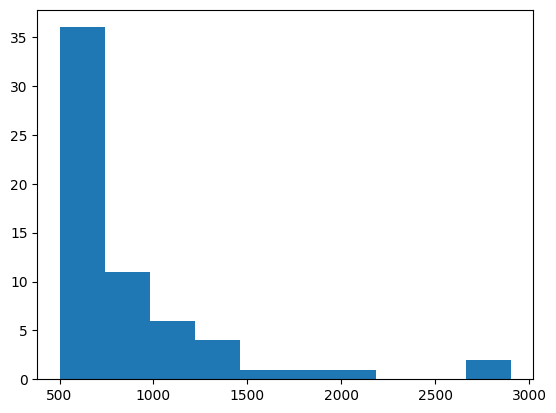

In [41]:
import matplotlib.pyplot as plt
keep = np.asarray(keep)
plt.hist(keep[keep > 500])

Plot

In [149]:
con_1 = res3['LER'] > 0
con_2 = res3['LER'] != np.inf

res = res3[con_1 & con_2]
res.reset_index(drop=True, inplace=True)


In [150]:
l_st = res[res['status']=='liquidate']
r_st = res[res['status']=='repaid']

In [151]:
l_sh = l_st.shape[0]
l_max = l_st['LER'].max()
l_min = l_st['LER'].min()
l_bound = l_st[l_st['LER']>1000].shape[0]
print(f'liquidate status')
print(f'min rate: {l_min}')
print(f'max rate: {l_max}')
print(f'greater than 1000: {l_bound}')
print(f'no data : {l_sh}\n')


r_sh = r_st.shape[0]
r_max = r_st['LER'].max()
r_min = r_st['LER'].min()
r_bound = r_st[r_st['LER']>10].shape[0]
print(f'repaid status')
print(f'min rate: {r_min}')
print(f'max rate: {r_max}')
print(f'greater than 100: {r_bound}')
print(f'no data  : {r_sh}')

liquidate status
min rate: 0.0340359365173839
max rate: 1.4407250372946256e+243
greater than 1000: 104
no data : 2553

repaid status
min rate: 2.842170943040401e-14
max rate: 26190010169.432087
greater than 100: 115
no data  : 17781


In [ ]:
l_sh = l_st.shape[0]
l_max = l_st['LER'].max()
l_min = l_st['LER'].min()
l_bound = l_st[l_st['LER']>1000].shape[0]
print(f'liquidate status')
print(f'min rate: {l_min}')
print(f'max rate: {l_max}')
print(f'greater than 1000: {l_bound}')
print(f'no data : {l_sh}\n')


r_sh = r_st.shape[0]
r_max = r_st['LER'].max()
r_min = r_st['LER'].min()
r_bound = r_st[r_st['LER']>10].shape[0]
print(f'repaid status')
print(f'min rate: {r_min}')
print(f'max rate: {r_max}')
print(f'greater than 100: {r_bound}')
print(f'no data  : {r_sh}')